=== Real Data Sample ===
   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ..

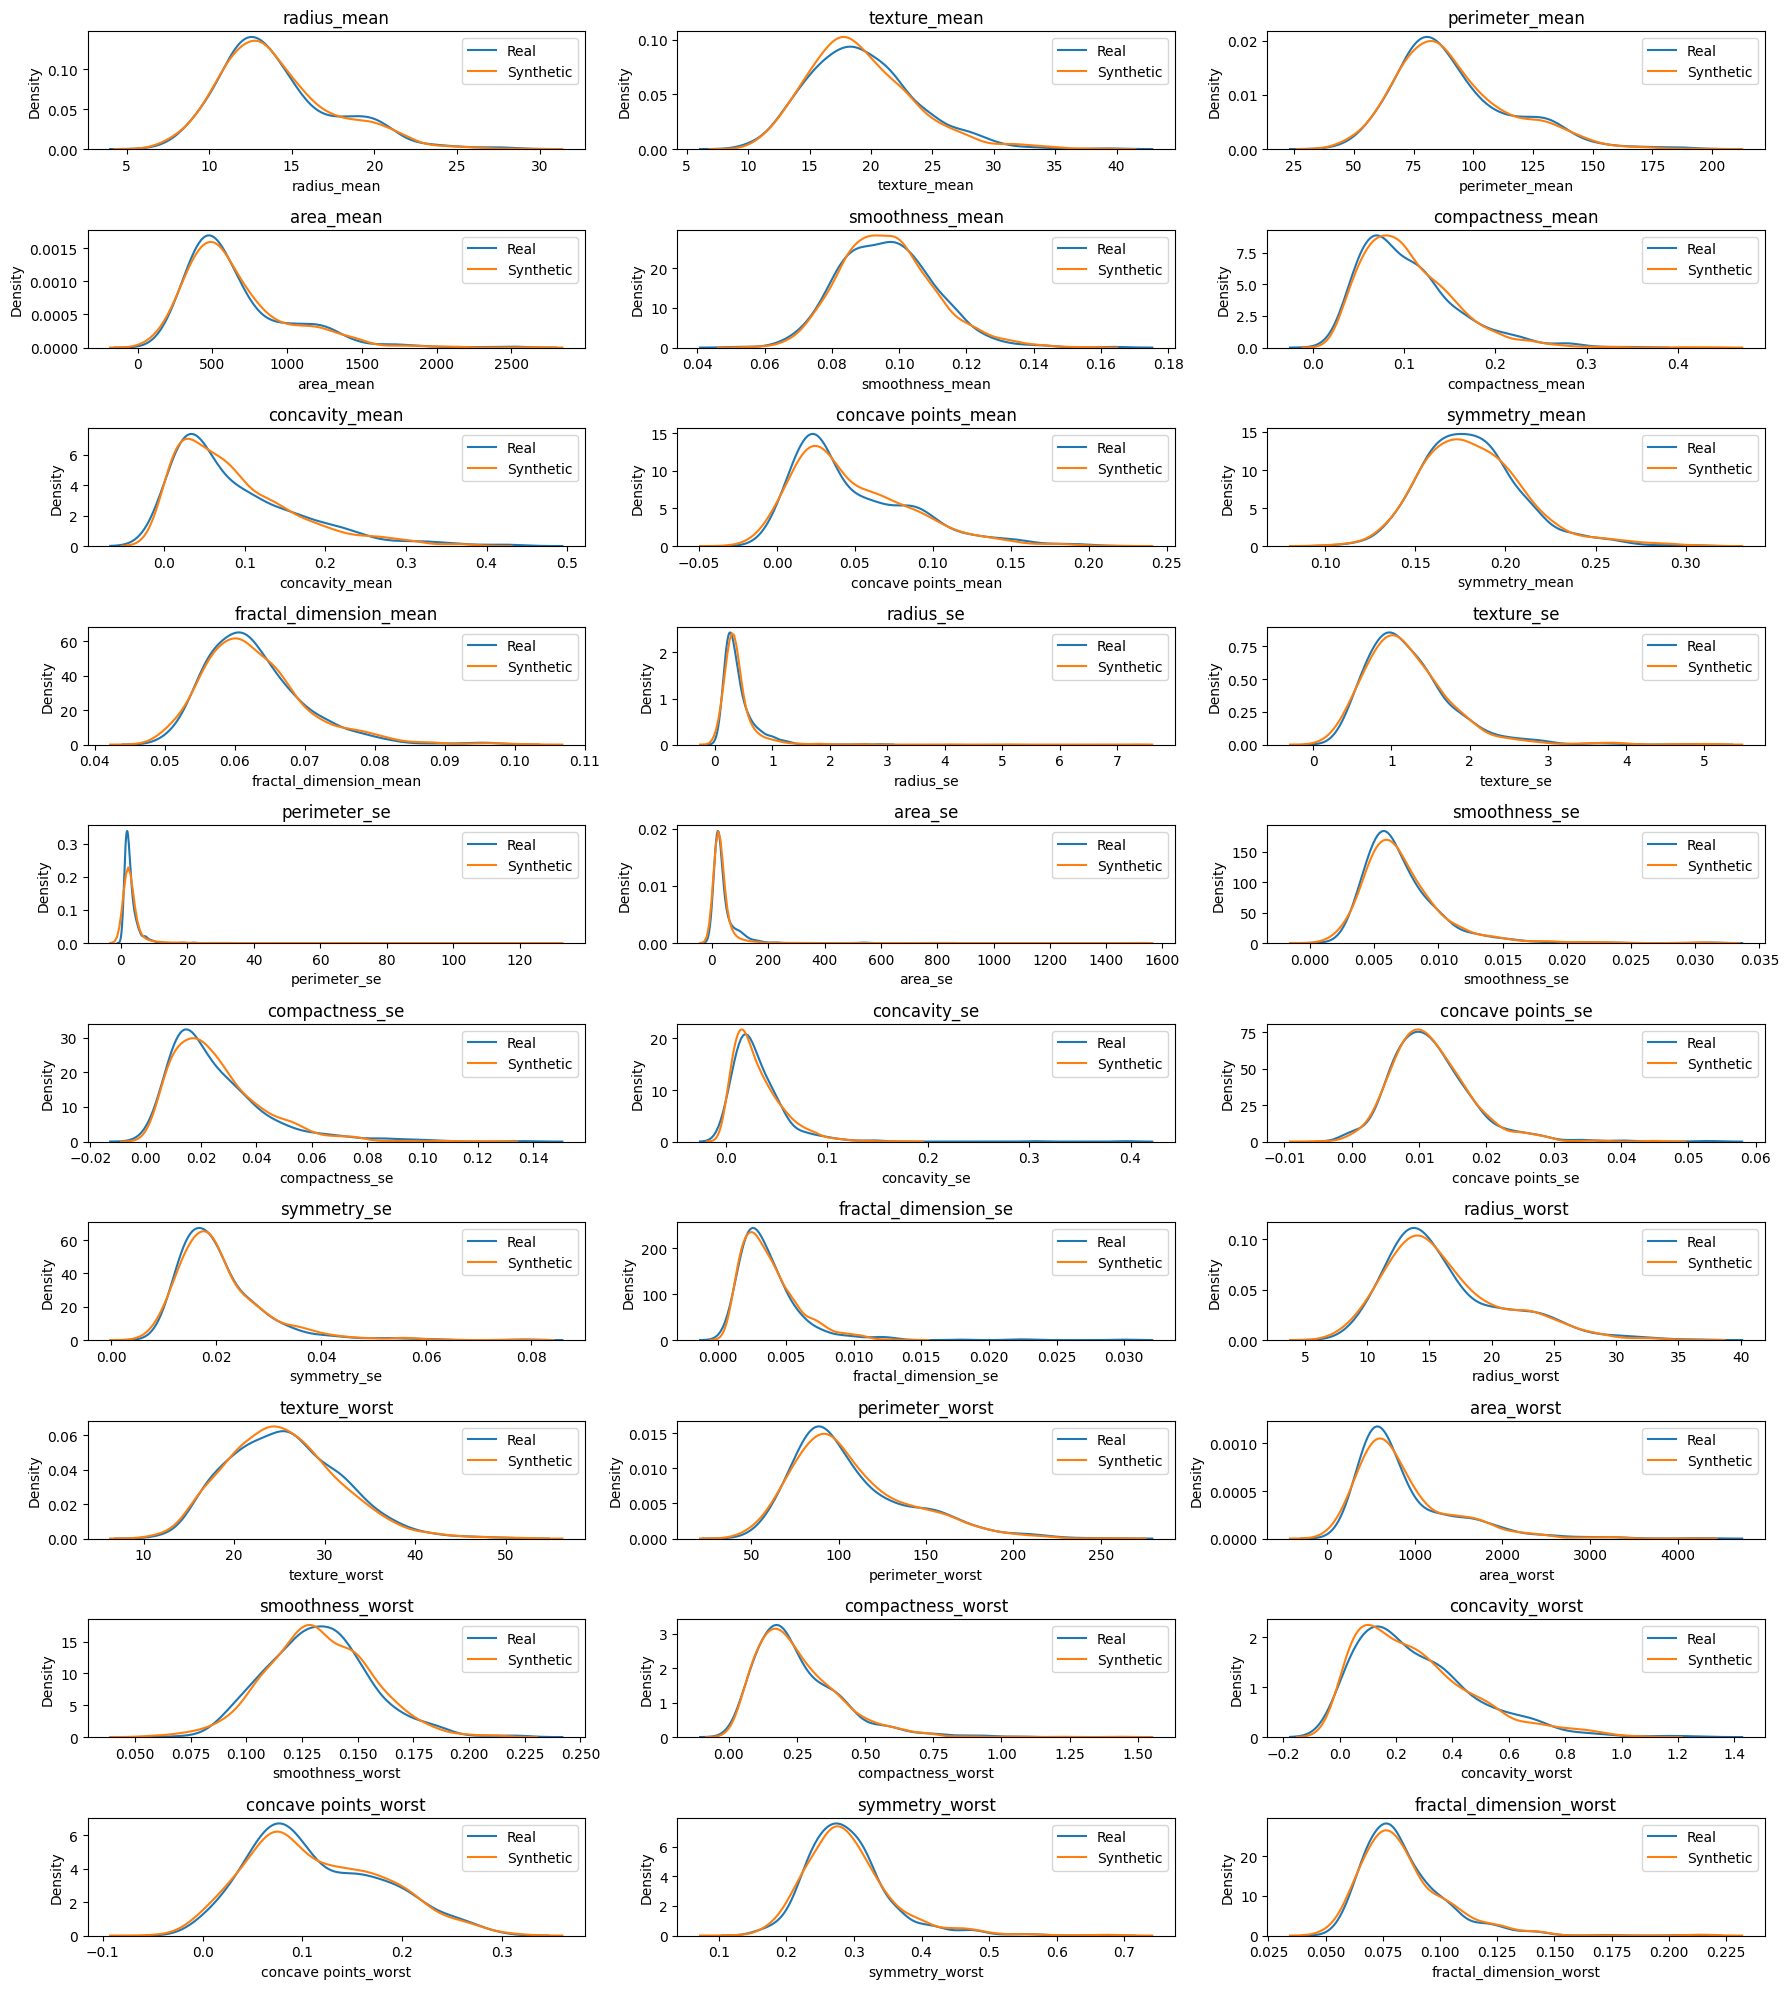


=== Classification Report (Trained on Synthetic, Tested on Real) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        71
           1       1.00      0.91      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from copulas.multivariate import GaussianMultivariate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# === Load and Prepare Real Data ===
df = pd.read_csv("C:/Users/jhumu/Downloads/data.csv")
df.drop(columns=["Unnamed: 32", "id"], errors="ignore", inplace=True)

# Encode target
le = LabelEncoder()
df["diagnosis"] = le.fit_transform(df["diagnosis"])  # M=1, B=0

print("=== Real Data Sample ===")
print(df.head())

# === Fit Copula Model ===
copula_model = GaussianMultivariate()
copula_model.fit(df)

# === Generate Synthetic Data (2x rows) ===
synthetic_df = copula_model.sample(num_rows=len(df) * 2)

# Clean up synthetic output
synthetic_df = synthetic_df.replace([np.inf, -np.inf], np.nan).dropna()

# Force the target column to binary: 0 or 1
if synthetic_df["diagnosis"].max() > 1:
    synthetic_df["diagnosis"] = synthetic_df["diagnosis"].apply(lambda x: 1 if x > 0.5 else 0)

# === Show Sample of Synthetic Data ===
print("\n=== Synthetic Data Sample ===")
print(synthetic_df.head())

# === Save Synthetic Data ===
synthetic_df.to_csv("C:/Users/jhumu/Regular Use/JupyNote/synthetic_data_copula_fixed.csv", index=False)

# === Visualize Distributions ===
numeric_cols = df.select_dtypes(include='number').columns.drop('diagnosis')
fig, axs = plt.subplots(len(numeric_cols) // 3, 3, figsize=(18, 20))
axs = axs.flatten()

for i, col in enumerate(numeric_cols[:len(axs)]):
    sns.kdeplot(df[col], label="Real", ax=axs[i])
    sns.kdeplot(synthetic_df[col], label="Synthetic", ax=axs[i])
    axs[i].set_title(col)
    axs[i].legend()

plt.tight_layout()
plt.show()

# === Evaluate Model Trained on Synthetic Data ===
X_real = df.drop("diagnosis", axis=1)
y_real = df["diagnosis"]

X_synth = synthetic_df.drop("diagnosis", axis=1)
y_synth = synthetic_df["diagnosis"]

# Ensure valid shape
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_synth, y_synth)
y_pred = model.predict(X_test_real)

print("\n=== Classification Report (Trained on Synthetic, Tested on Real) ===")
print(classification_report(y_test_real, y_pred))


In [3]:
# After loading real data
print("Real Data Size:", df.shape)

# After generating synthetic data
print("Synthetic Data Size:", synthetic_df.shape)

Real Data Size: (569, 31)
Synthetic Data Size: (1138, 31)


In [4]:
df.shape[0]              # Real data rows (e.g., 569)
synthetic_df.shape[0]    # Synthetic data rows (e.g., 1138)


1138

In [5]:
print("Synthetic / Real Ratio:", synthetic_df.shape[0] / df.shape[0])


Synthetic / Real Ratio: 2.0
